In [2]:
import time
import torch
from torch import nn, optim
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
import PIL
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
#选择设备

print(torch.cuda.is_available())
from torchvision import transforms 
from torchvision import datasets
import os
from torchvision import models


#选择设备

device = torch.device("cuda:0")

#对三种数据集进行不同预处理，对训练数据进行加强

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomRotation(30),

        transforms.RandomResizedCrop(224),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406],

                             [0.229, 0.224, 0.225])

    ]),

    'valid': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406],

                             [0.229, 0.224, 0.225])

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406],

                             [0.229, 0.224, 0.225])

    ])

}

 

#数据目录


data_dir = r"E:\Summer Research\final task\data"

 

#获取三个数据集

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

                 data_transforms[x]) for x in ['train', 'valid','test']}

traindataset = image_datasets['train']

validdataset = image_datasets['valid']

testdataset = image_datasets['test']

 

batch_size = 16

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,

             shuffle=True, num_workers=4) for x in ['train', 'valid','test']}

print(dataloaders)

traindataloader = dataloaders['train']

validdataloader = dataloaders['valid']

testdataloader = dataloaders['test']

 

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}




True
{'train': <torch.utils.data.dataloader.DataLoader object at 0x000001B59CBE7A90>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x000001B59CBF8A00>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000001B59CBF8B20>}


In [3]:
class Net(nn.Module):

    def __init__(self,model):

        super(Net,self).__init__()

        self.resnet = nn.Sequential(*list(model.children())[:-1])

        # Freeze parameters of convoluntional layers

        # for p in self.parameters():

        #     p.requires_grad = False

        self.fc = nn.Linear(in_features=2048,out_features=2)

        
    def forward(self,x):

        x = self.resnet(x)

        x = x.view(x.shape[0], -1)

        x = self.fc(x)

        return x

 
resnet152 = models.resnet152(pretrained=True)

net = Net(resnet152)

In [33]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),lr=0.0001,momentum=0.9)

In [34]:
def valid_model(model, criterion):

    best_acc = 0.0

    # print('-' * 10)

 

    running_loss = 0.0

    running_corrects = 0

    model = model.to(device)

    for inputs, labels in validdataloader:

        inputs = inputs.to(device)

        labels = labels.to(device)

        model.eval()

        with torch.no_grad():

            outputs = model(inputs)

        loss = criterion(outputs, labels)

 

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()

        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / dataset_sizes['valid']

    # print(running_corrects.double())

    epoch_acc = running_corrects.double() / dataset_sizes['valid']

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(

            'valid', epoch_loss, epoch_acc))

    # print('-' * 10)

    print()

In [35]:
def test_model(model, criterion):

    best_acc = 0.0

    # print('-' * 10)

 

    running_loss = 0.0

    running_corrects = 0

    model = model.to(device)

    for inputs, labels in testdataloader:

        inputs = inputs.to(device)

        labels = labels.to(device)

        model.eval()

        with torch.no_grad():

            outputs = model(inputs)

        loss = criterion(outputs, labels)

 

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()

        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / dataset_sizes['test']

    # print(running_corrects.double())

    epoch_acc = running_corrects.double() / dataset_sizes['test']

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(

            'test', epoch_loss, epoch_acc))

    # print('-' * 10)

    #print()

In [36]:
def train_model(model, criterion, optimizer, num_epochs=5):

    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):

        # since = time.time()
        
        # print('-' * 10)

        print('Epoch {}'.format(epoch))

 

        running_loss = 0.0

        running_corrects = 0

        model = model.to(device)

        for inputs, labels in traindataloader:

            inputs = inputs.to(device)

            labels = labels.to(device)

            model.train()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

 

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item()

            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / dataset_sizes['train']

        # print(dataset_sizes['train'])

        # print(running_corrects.double())

        epoch_acc = running_corrects.double() / dataset_sizes['train']

        best_acc = max(best_acc,epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))

        valid_model(model, criterion)
 
        time_elapsed = time.time() - since

        # print('use time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        # print()

 


    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))

 

    return model

In [14]:
epochs = 60
# model = torch.load(r'E:\Ud project\model1.pkl')
model = train_model(net, criterion, optimizer, epochs)
# model = train_model(model, criterion, optimizer, epochs)
test_model(model,criterion)
torch.save(model, r'E:\Summer Research\final task\model2021_6_23.pkl')

Epoch 0
train Loss: 0.0818 Acc: 0.6300
valid Loss: 0.0520 Acc: 0.7250

Epoch 1
train Loss: 0.0345 Acc: 0.8850
valid Loss: 0.0313 Acc: 0.8917

Epoch 2
train Loss: 0.0252 Acc: 0.9000
valid Loss: 0.0238 Acc: 0.8833

Epoch 3
train Loss: 0.0211 Acc: 0.9150
valid Loss: 0.0231 Acc: 0.9250

Epoch 4
train Loss: 0.0179 Acc: 0.9200
valid Loss: 0.0199 Acc: 0.9333

Epoch 5
train Loss: 0.0165 Acc: 0.9100
valid Loss: 0.0189 Acc: 0.9250

Epoch 6
train Loss: 0.0165 Acc: 0.9075
valid Loss: 0.0179 Acc: 0.9333

Epoch 7
train Loss: 0.0142 Acc: 0.9375
valid Loss: 0.0158 Acc: 0.9250

Epoch 8
train Loss: 0.0147 Acc: 0.9200
valid Loss: 0.0137 Acc: 0.9250

Epoch 9
train Loss: 0.0148 Acc: 0.9250
valid Loss: 0.0146 Acc: 0.9333

Epoch 10
train Loss: 0.0141 Acc: 0.9350
valid Loss: 0.0130 Acc: 0.9333

Epoch 11
train Loss: 0.0128 Acc: 0.9350
valid Loss: 0.0133 Acc: 0.9250

Epoch 12
train Loss: 0.0149 Acc: 0.9100
valid Loss: 0.0130 Acc: 0.9250

Epoch 13
train Loss: 0.0147 Acc: 0.9075
valid Loss: 0.0140 Acc: 0.9333

Ep

In [7]:
epochs = 40
# model = torch.load(r'E:\Ud project\model1.pkl')
model = train_model(net, criterion, optimizer, epochs)
# model = train_model(model, criterion, optimizer, epochs)
test_model(model,criterion)
torch.save(model, r'E:\Summer Research\final task\model2021_6_23_2.pkl')

Epoch 0
train Loss: 0.0831 Acc: 0.6100
valid Loss: 0.0535 Acc: 0.7917

Epoch 1
train Loss: 0.0351 Acc: 0.8800
valid Loss: 0.0348 Acc: 0.8583

Epoch 2
train Loss: 0.0285 Acc: 0.8800
valid Loss: 0.0292 Acc: 0.8583

Epoch 3
train Loss: 0.0218 Acc: 0.9150
valid Loss: 0.0233 Acc: 0.8917

Epoch 4
train Loss: 0.0189 Acc: 0.9075
valid Loss: 0.0221 Acc: 0.8833

Epoch 5
train Loss: 0.0174 Acc: 0.9200
valid Loss: 0.0189 Acc: 0.9250

Epoch 6
train Loss: 0.0156 Acc: 0.9250
valid Loss: 0.0171 Acc: 0.9250

Epoch 7
train Loss: 0.0161 Acc: 0.9175
valid Loss: 0.0168 Acc: 0.9333

Epoch 8
train Loss: 0.0146 Acc: 0.9300
valid Loss: 0.0172 Acc: 0.9167

Epoch 9
train Loss: 0.0137 Acc: 0.9350
valid Loss: 0.0155 Acc: 0.9167

Epoch 10
train Loss: 0.0126 Acc: 0.9350
valid Loss: 0.0154 Acc: 0.9417

Epoch 11
train Loss: 0.0121 Acc: 0.9425
valid Loss: 0.0135 Acc: 0.9417

Epoch 12
train Loss: 0.0146 Acc: 0.9200
valid Loss: 0.0139 Acc: 0.9167

Epoch 13
train Loss: 0.0135 Acc: 0.9350
valid Loss: 0.0162 Acc: 0.9083

Ep

In [7]:
epochs = 20
# model = torch.load(r'E:\Ud project\model1.pkl')
model = train_model(net, criterion, optimizer, epochs)
# model = train_model(model, criterion, optimizer, epochs)
test_model(model,criterion)
torch.save(model, r'E:\Summer Research\final task\model2021_6_23_2.pkl')

Epoch 0
train Loss: 0.1024 Acc: 0.4083
valid Loss: 0.0598 Acc: 0.7417

Epoch 1
train Loss: 0.0385 Acc: 0.8944
valid Loss: 0.0382 Acc: 0.8500

Epoch 2
train Loss: 0.0281 Acc: 0.9111
valid Loss: 0.0285 Acc: 0.9000

Epoch 3
train Loss: 0.0227 Acc: 0.9028
valid Loss: 0.0249 Acc: 0.8917

Epoch 4
train Loss: 0.0216 Acc: 0.9000
valid Loss: 0.0229 Acc: 0.9167

Epoch 5
train Loss: 0.0184 Acc: 0.9306
valid Loss: 0.0241 Acc: 0.8500

Epoch 6
train Loss: 0.0182 Acc: 0.9056
valid Loss: 0.0174 Acc: 0.9250

Epoch 7
train Loss: 0.0161 Acc: 0.9222
valid Loss: 0.0174 Acc: 0.9250

Epoch 8
train Loss: 0.0160 Acc: 0.9194
valid Loss: 0.0160 Acc: 0.9167

Epoch 9
train Loss: 0.0159 Acc: 0.9139
valid Loss: 0.0190 Acc: 0.9083

Epoch 10
train Loss: 0.0133 Acc: 0.9389
valid Loss: 0.0175 Acc: 0.9167

Epoch 11
train Loss: 0.0158 Acc: 0.9222
valid Loss: 0.0160 Acc: 0.9167

Epoch 12
train Loss: 0.0138 Acc: 0.9306
valid Loss: 0.0146 Acc: 0.9250

Epoch 13
train Loss: 0.0132 Acc: 0.9250
valid Loss: 0.0150 Acc: 0.9167

Ep

In [37]:
epochs = 30
# model = torch.load(r'E:\Ud project\model1.pkl')
model = train_model(net, criterion, optimizer, epochs)
# model = train_model(model, criterion, optimizer, epochs)
test_model(model,criterion)
torch.save(model, r'E:\Summer Research\final task\model2021_6_30.pkl')

Epoch 0
train Loss: 0.0415 Acc: 0.6750
valid Loss: 0.0376 Acc: 0.7750

Epoch 1
train Loss: 0.0316 Acc: 0.8917
valid Loss: 0.0306 Acc: 0.9083

Epoch 2
train Loss: 0.0257 Acc: 0.9056
valid Loss: 0.0247 Acc: 0.9000

Epoch 3
train Loss: 0.0211 Acc: 0.9083
valid Loss: 0.0237 Acc: 0.9000

Epoch 4
train Loss: 0.0208 Acc: 0.8972
valid Loss: 0.0207 Acc: 0.9083

Epoch 5
train Loss: 0.0178 Acc: 0.9250
valid Loss: 0.0187 Acc: 0.9083

Epoch 6
train Loss: 0.0178 Acc: 0.9111
valid Loss: 0.0178 Acc: 0.9167

Epoch 7
train Loss: 0.0176 Acc: 0.9139
valid Loss: 0.0178 Acc: 0.9083

Epoch 8
train Loss: 0.0167 Acc: 0.9056
valid Loss: 0.0172 Acc: 0.9333

Epoch 9
train Loss: 0.0145 Acc: 0.9250
valid Loss: 0.0155 Acc: 0.9417

Epoch 10
train Loss: 0.0160 Acc: 0.9111
valid Loss: 0.0146 Acc: 0.9333

Epoch 11
train Loss: 0.0141 Acc: 0.9306
valid Loss: 0.0151 Acc: 0.9250

Epoch 12
train Loss: 0.0144 Acc: 0.9278
valid Loss: 0.0146 Acc: 0.9333

Epoch 13
train Loss: 0.0169 Acc: 0.9111
valid Loss: 0.0158 Acc: 0.9167

Ep

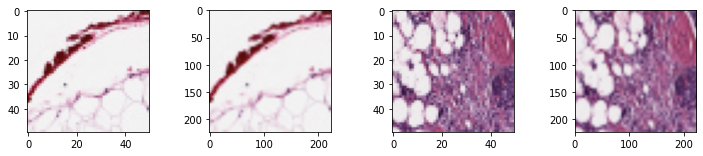

'\nplt.figure()\n\nplt.subplot(1,2,1)\n\nplt.imshow(image)\n\nT11 = torchvision.transforms.Resize(256)  #调整尺寸 \n\nimage1 = T11(image)\n\nT12 = transforms.CenterCrop(224)\n\nimage2 = T12(image1)\n\nplt.subplot(1,2,2)\n\nplt.imshow(image2) \n\nplt.show() \n'

In [5]:
import torch

import torchvision 

import matplotlib.pyplot as plt

from PIL import Image

 

img = Image.open(r'E:\Summer Research\final task\data\train\0\0-1.png')

plt.figure()

plt.subplot(1,4,1)

plt.imshow(img)

 

T1 = torchvision.transforms.RandomRotation(30) #随机水平翻转

img1 = T1(img)

T2 = torchvision.transforms.Resize(224) # 随机裁剪 

img2 = T2(img)

T3 = torchvision.transforms.RandomHorizontalFlip() # 随机水平翻转

img3 = T3(img2)

plt.subplot(1,4,2)

plt.imshow(img3) 

plt.subplot(1,4,3)

image = Image.open(r'E:\Summer Research\final task\data\train\1\1-1.png')

plt.imshow(image)



T1 = torchvision.transforms.RandomRotation(30) #随机水平翻转

img1 = T1(img)

T2 = torchvision.transforms.Resize(224) # 随机裁剪 

img2 = T2(image)

T3 = torchvision .transforms.RandomHorizontalFlip() # 随机水平翻转

img3 = T3(img2)

plt.subplot(1,4,4)

plt.imshow(img3) 

plt.rcParams['figure.figsize'] = (15.0, 15.0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.5, hspace=None)

plt.show() 
"""
plt.figure()

plt.subplot(1,2,1)

plt.imshow(image)

T11 = torchvision.transforms.Resize(256)  #调整尺寸 

image1 = T11(image)

T12 = transforms.CenterCrop(224)

image2 = T12(image1)

plt.subplot(1,2,2)

plt.imshow(image2) 

plt.show() 
"""

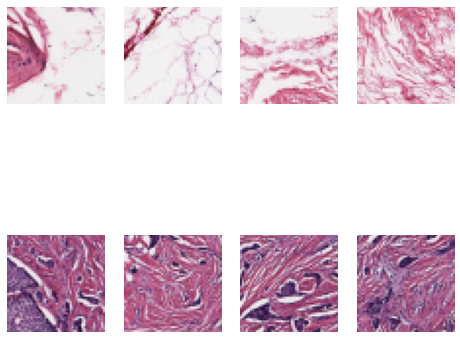

In [13]:
import torch

import torchvision 

import matplotlib.pyplot as plt

from PIL import Image



img = Image.open(r'E:\Summer Research\final task\data\train\0\0-3.png')

plt.figure()

plt.subplot(2,4,1)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\0\0-4.png')

plt.axis('off')

plt.subplot(2,4,2)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\0\0-5.png')

plt.axis('off')

plt.subplot(2,4,3)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\0\0-6.png')

plt.axis('off')

plt.subplot(2,4,4)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\1\1-3.png')

plt.axis('off')

plt.subplot(2,4,5)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\1\1-4.png')

plt.axis('off')

plt.subplot(2,4,6)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\1\1-5.png')

plt.axis('off')

plt.subplot(2,4,7)

plt.imshow(img)

img = Image.open(r'E:\Summer Research\final task\data\train\1\1-6.png')

plt.axis('off')

plt.subplot(2,4,8)

plt.imshow(img)

plt.rcParams['figure.figsize'] = (8.0, 8.0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.2, hspace=0.1)

plt.axis('off')

 

plt.show() 